In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
from tqdm import tqdm

In [200]:
def kernel_function_matrix(kernel_function, x,d):
    # input x should be a (n,) vector
    kernel_function2 = lambda x1,x2: kernel_function(x1,x2,d)
    n = x.shape[0]
    res = np.zeros((n,n),dtype = np.double)
    for i in range(n):
        for j in range(n):
            res[i,j] = kernel_function2(x[i],x[j])
    return res
    
def leave_one_out_CV(KSS, X,y, true_f,ds, lmbdas,kernel_func):
    lmbda_opt = None; d_opt = None; error_opt = 100000000;
    n = X.shape[0]
    for d in ds :
        for lmbda in lmbdas :
            KSS.lmbda = lmbda
            l2 = []
            for i in range(n):
                KSS.theta = None;
                KSS.prediction = None;
                X_cp = X[np.arange(n)!=i]
                y_cp = y[np.arange(n)!=i]
                K = kernel_function_matrix(kernel_func,X_cp,d)
                KSS.train(K,y_cp)
                KSS.predict(kernel_func,X[i],X_cp,d)
                l2.append(KSS.prediction)
            mse_error = 1/n * np.sum(np.power(true_f - np.array(l2),2))
            if (mse_error < error_opt) :
                error_opt = mse_error
                d_opt = d
                lmbda_opt = lmbda
    return lmbda_opt,d_opt,error_opt
                
    

In [201]:
class KernelRedgeReg:
    def __init__(self, lmbda, theta = None):
        self.lmbda = lmbda
        self.theta = theta
        self.prediction = None
        
    def train(self,K, y):
        n = y.shape[0]
        
        self.theta = linalg.solve(K + self.lmbda * 
                                  np.eye(n,dtype = np.double), y)  # A\b
    
    def predict(self,kernel_func, test_x, train_x,d):
        kernel_func2 = lambda x1: kernel_func(x1,test_x,d)
        prediction = 0
        for a, x in zip(self.theta, train_x):
            prediction += a * kernel_func2(x)
        self.prediction = prediction
        
        

In [214]:
d = 30;n = 30

X =np.random.uniform(0,1,30)
f = lambda x : 4 * np.sin(np.pi * x) * np.cos(6* np.pi * x**2)
y = f(X) + np.random.normal(0,1,30)

#kernel_func = lambda x1,x2,d: (1 + x1*x2)**d
kernel_func = lambda x1,x2,d: np.exp(-d*np.power((x1 - x2),2))
K = kernel_function_matrix(kernel_func,X,d)

In [215]:
KRR = KernelRedgeReg(lmbda=None)
ds = [1,5,10,20,50,100,1000,10000]
lmbdas = [0.001,0.01,0.1,.5,1,10,100,1000,10000]
lmbda_opt,d_opt,error_opt = leave_one_out_CV(KRR, X, y, f(X),ds, lmbdas,kernel_func)


In [216]:
print(lmbda_opt)
print(d_opt)
print(error_opt)

0.1
100
0.4936774352898786


In [217]:
#print(KRR.theta)
X_copy= np.sort(np.copy(X))
print(X_copy)
KRR.lmbda = lmbda_opt
K_opt = kernel_function_matrix(kernel_func,X,d_opt)
KRR.train(K_opt,y)
pred_list =[]
for m in X_copy: 
    KRR.predict(kernel_func,m,X,d_opt) 
    pred_list.append(KRR.prediction)

[0.00442515 0.0593205  0.06209091 0.09439067 0.10107702 0.10407601
 0.12471815 0.1479736  0.17997288 0.23431843 0.2348818  0.24835054
 0.2761303  0.34902298 0.38729075 0.42695675 0.44678877 0.4885613
 0.55995082 0.6027632  0.6126501  0.62687045 0.64060802 0.65420786
 0.76011757 0.78929299 0.81118125 0.86949788 0.96113647 0.96737771]


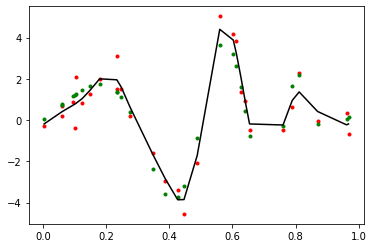

In [218]:
plt.plot(X,y,"r.")
plt.plot(X,f(X),"g.")
plt.plot(X_copy,pred_list,'k-')